## Conditional Image Synthesis with Auxiliary Classifier GANs (2017)
- one of the Conditional GANs
- cGan -> sGan -> **acGan** -> infoGan

## Features
- The discriminator does two jobs.
    - job1 : Is this image real/fake? (Original Discriminator)
    - job2 : What is this image class? (Classifier)
- loss function
    - job1 loss : <br>$ L_{s} = E[logP(S = real | X_{real})] + E[logP(S=fake|X_{fake})]$
    - job2 loss : <br>$ L_{c} = E[logP(C = c | X_{real})] + E[logP(C=c|X_{fake})]$
- Discriminator maximizes $ L_{s} + L_{c} $
- Generator maximizes $ L_{c} - L_{s} $
- Others are same with my [DCGAN implementation](https://github.com/ZeroAct/GANs/blob/main/2_DCGAN/DCGAN.ipynb)


## Dataset
- Fashion MNist

## Import Modules

In [1]:
import sys
sys.path.insert(0, '../')

import os
import cv2
import tqdm
import random

import numpy as np

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import FashionMNIST

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 4)

from utils import imshow, get_mean

random_seed = 123

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Download Fashion MNist
- We don't validate or test here.

In [2]:
os.makedirs('../dataset', exist_ok=True)

train_data = FashionMNIST('../dataset', train=True, download=True)
#test_data = FashionMNIST('../dataset', train=False, download=True)

In [3]:
classes = train_data.classes
train_images, train_labels = train_data.data, train_data.targets
#test_images, test_labels = test_data.data, test_data.targets

print(f"{len(train_images)} train images...")
#print(f"{len(test_images)} test images...")

60000 train images...


In [4]:
class_num = len(train_labels.unique())
print(f"class num : {class_num}")

class num : 10


<Figure size 864x288 with 0 Axes>

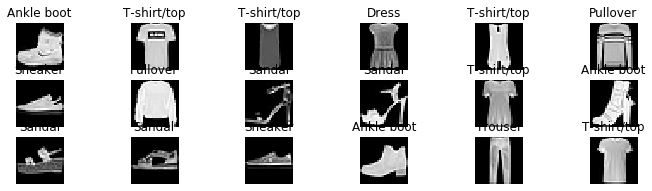

In [5]:
imshow(train_images[:18], train_labels[:18], classes)

## Build Network

### Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        # smaller than the paper architecture
        self.model = nn.Sequential(
            # (1 x 1) -> (4 x 4)
            nn.ConvTranspose2d(100 + class_num, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # (4 x 4) -> (7 x 7)
            nn.ConvTranspose2d(512, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # (7 x 7) -> (14 x 14)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (14 x 14) -> (28 x 28)
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, z, y_vec):
        x = self.model(torch.cat((z, y_vec.view(-1, class_num, 1, 1)), dim=1))
        return x

### Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.head = nn.Sequential(
            # (28 x 28) -> (14 x 14)
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # (14 x 14) -> (7 x 7)
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # (7 x 7) -> (3 x 3)
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # real/fake net
        self.rfnet = nn.Sequential(
            # (3 x 3) -> (1 x 1)
            nn.Conv2d(512, 1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )
        
        # classifier
        self.classifier = nn.Sequential(
            # (3 x 3) -> (1 x 1)
            nn.Conv2d(512, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.head(x)
        
        rf = self.rfnet(x)
        cl = self.classifier(x)
        
        return rf.view(-1, 1), cl

In [8]:
G = Generator().to(device)
D = Discriminator().to(device)

### weight initialize

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    print(f"initialized {classname}")

In [10]:
G.apply(weights_init)
D.apply(weights_init)
print("success")

initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized BatchNorm2d
initialized ReLU
initialized ConvTranspose2d
initialized Tanh
initialized Sequential
initialized Generator
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Sequential
initialized Conv2d
initialized Sigmoid
initialized Sequential
initialized Conv2d
initialized BatchNorm2d
initialized LeakyReLU
initialized Flatten
initialized Linear
initialized Sequential
initialized Discriminator
success


## Sampling function
- sampling latent z
- z.shape -> (batch_size, dim, 1, 1)

In [11]:
def sample_z(num=1, dim=100):
    return torch.randn(num, dim, 1, 1)

<Figure size 864x288 with 0 Axes>

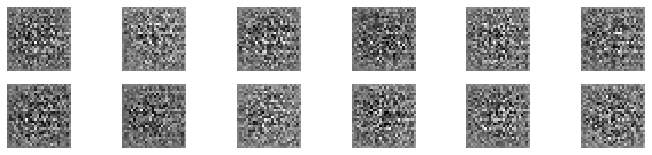

In [12]:
fake = G(sample_z(12, 100).to(device), torch.randn(12, 10).to(device))
imshow(fake.detach().cpu().reshape(-1, 28, 28))

## Hyperparameters

In [13]:
batch_size    = 64
learning_rate = 0.001
epochs        = 100

## Optimizer

In [14]:
optim_D = optim.Adam(D.parameters(), learning_rate)
optim_G = optim.Adam(G.parameters(), learning_rate)

## Loss Function

In [15]:
bce = F.binary_cross_entropy
ce = F.cross_entropy
ones = torch.ones(batch_size, 1).to(device)
zeros = torch.zeros(batch_size, 1).to(device)

def loss_fn_D(D, G, real, fake, target):
    rf_r, yhat_r = D(real)
    rf_f, yhat_f = D(fake)
    Ls = bce(rf_r, ones) + bce(rf_f, zeros)
    Lc = ce(yhat_r, target) + ce(yhat_f, target)
    return Ls + Lc

def loss_fn_G(D, G, fake, target):
    rf_f, yhat_f = D(fake)
    Ls = bce(rf_f, ones)
    Lc = ce(yhat_f, target)
    return Ls + 1.1 * Lc

## Build CustomDataset and Dataloader

In [16]:
class CustomDataset(Dataset):
    def __init__(self):
        super(CustomDataset).__init__()
        
        self.xs = train_images * (2 / 255) - 1.
        print(f"normalized [{self.xs.min()}, {self.xs.max()}]")
        
        self.ys_ = train_labels
        self.ys = torch.zeros(len(self.ys_), class_num)
        for i, y in enumerate(self.ys_):
            self.ys[i, y] = 1
        print(self.ys.dtype)
    
    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x.view(1, 28, 28), y

In [17]:
dataloader_params = {'batch_size': batch_size,
                     'shuffle': True,
                     'drop_last': True,
                     'num_workers': 0}

train_ds = CustomDataset()
train_gen = DataLoader(train_ds, **dataloader_params)

normalized [-1.0, 1.0]
torch.float32


## Training

Epoch 0/100 G_loss : 8.435488 D_loss : 2.431998: 100%|███████████████████████████████| 937/937 [00:44<00:00, 20.85it/s]


<Figure size 864x288 with 0 Axes>

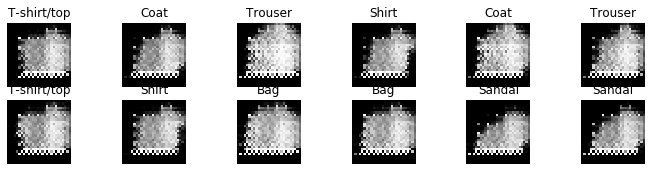

Epoch 1/100 G_loss : 8.814366 D_loss : 0.699514: 100%|███████████████████████████████| 937/937 [00:45<00:00, 20.59it/s]


<Figure size 864x288 with 0 Axes>

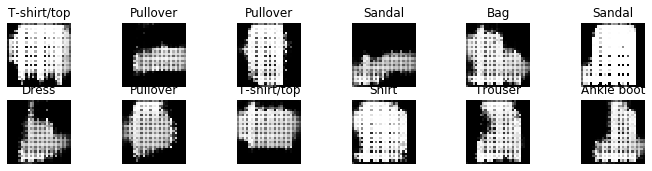

Epoch 2/100 G_loss : 7.685087 D_loss : 0.801919: 100%|███████████████████████████████| 937/937 [00:44<00:00, 21.08it/s]


<Figure size 864x288 with 0 Axes>

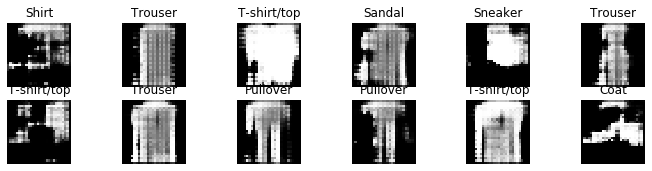

Epoch 3/100 G_loss : 7.180198 D_loss : 0.714805: 100%|███████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

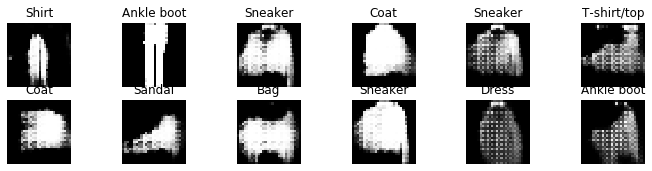

Epoch 4/100 G_loss : 7.257375 D_loss : 0.658526: 100%|███████████████████████████████| 937/937 [00:43<00:00, 21.50it/s]


<Figure size 864x288 with 0 Axes>

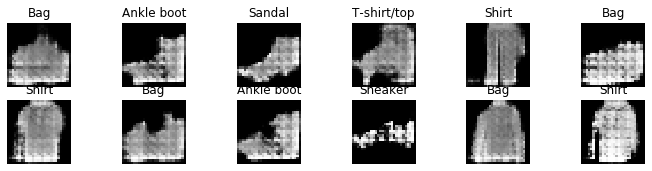

Epoch 5/100 G_loss : 6.529058 D_loss : 0.638239: 100%|███████████████████████████████| 937/937 [00:43<00:00, 21.44it/s]


<Figure size 864x288 with 0 Axes>

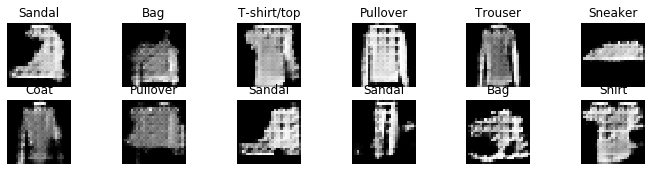

Epoch 6/100 G_loss : 6.320192 D_loss : 0.627877: 100%|███████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

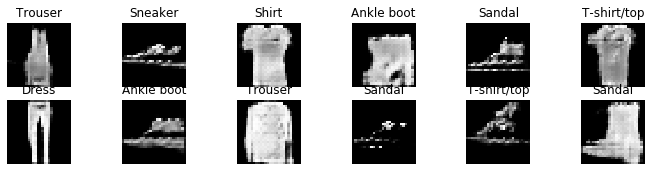

Epoch 7/100 G_loss : 5.850995 D_loss : 0.620458: 100%|███████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

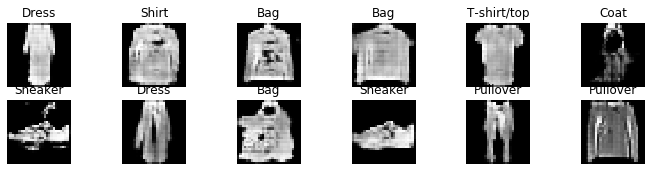

Epoch 8/100 G_loss : 5.484705 D_loss : 0.573392: 100%|███████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

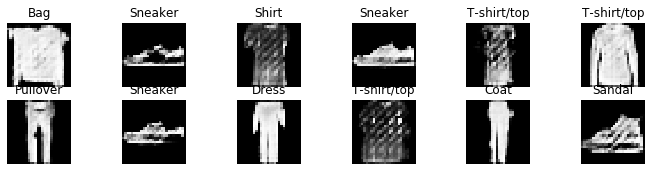

Epoch 9/100 G_loss : 5.800048 D_loss : 0.589174: 100%|███████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

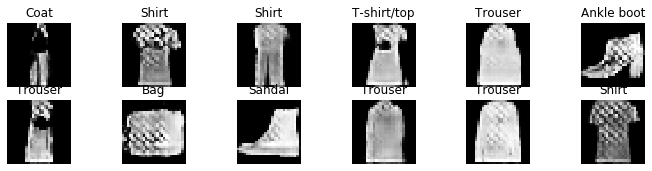

Epoch 10/100 G_loss : 5.332926 D_loss : 0.595098: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

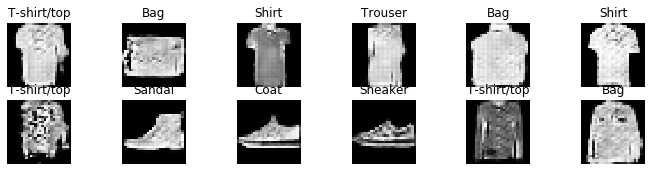

Epoch 11/100 G_loss : 4.952679 D_loss : 0.569086: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

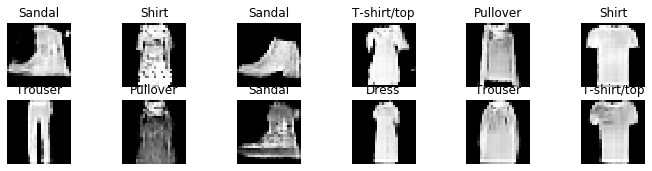

Epoch 12/100 G_loss : 4.807685 D_loss : 0.586003: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

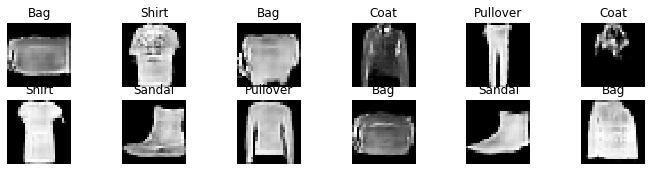

Epoch 13/100 G_loss : 4.537304 D_loss : 0.563344: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

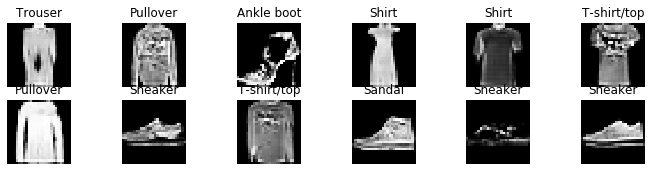

Epoch 14/100 G_loss : 4.452370 D_loss : 0.587511: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

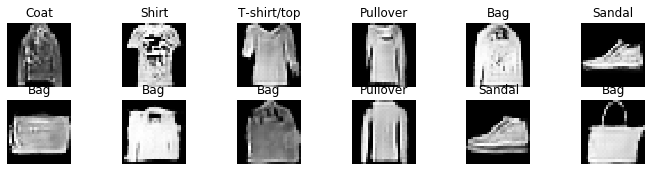

Epoch 15/100 G_loss : 4.260842 D_loss : 0.564867: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

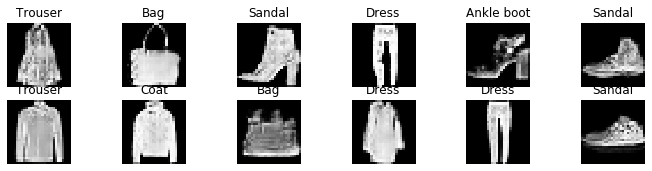

Epoch 16/100 G_loss : 4.260801 D_loss : 0.532490: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

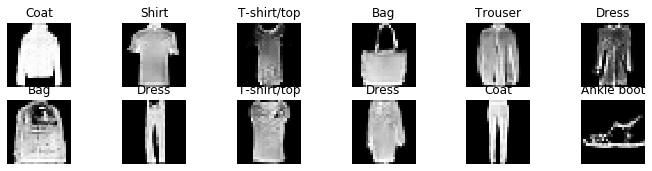

Epoch 17/100 G_loss : 4.278195 D_loss : 0.514735: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

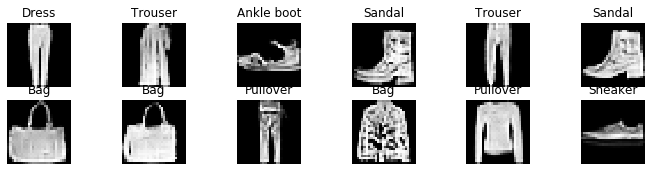

Epoch 18/100 G_loss : 4.230558 D_loss : 0.504002: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

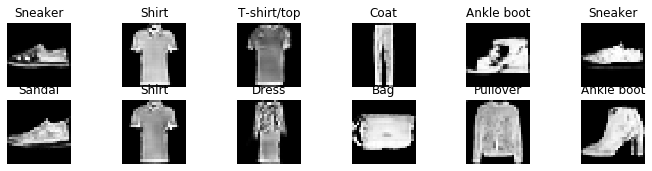

Epoch 19/100 G_loss : 4.248543 D_loss : 0.504577: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

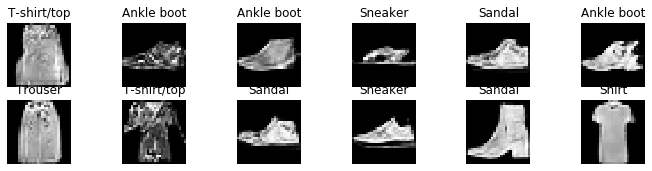

Epoch 20/100 G_loss : 4.222968 D_loss : 0.477299: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.37it/s]


<Figure size 864x288 with 0 Axes>

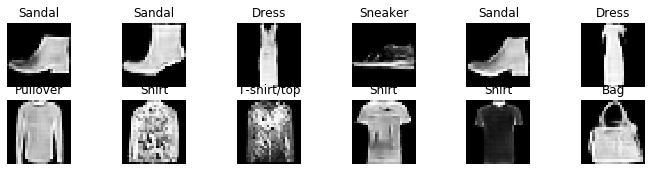

Epoch 21/100 G_loss : 4.227240 D_loss : 0.498693: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

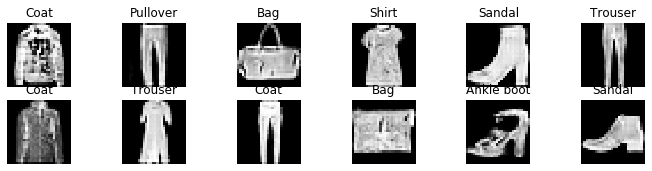

Epoch 22/100 G_loss : 4.087615 D_loss : 0.476284: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

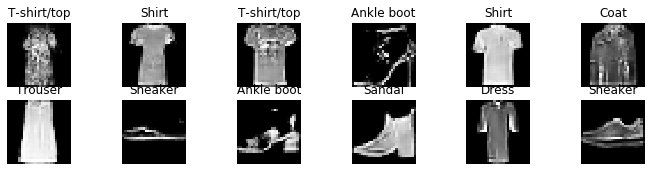

Epoch 23/100 G_loss : 4.182777 D_loss : 0.446605: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.38it/s]


<Figure size 864x288 with 0 Axes>

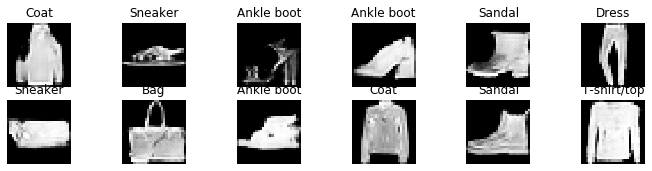

Epoch 24/100 G_loss : 4.121111 D_loss : 0.445403: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.43it/s]


<Figure size 864x288 with 0 Axes>

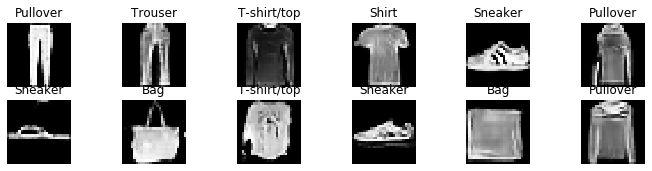

Epoch 25/100 G_loss : 4.196227 D_loss : 0.428768: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

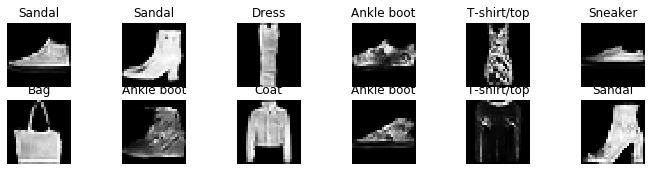

Epoch 26/100 G_loss : 4.215632 D_loss : 0.434392: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

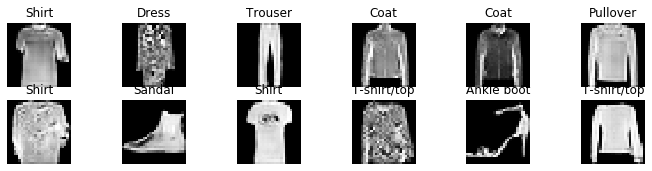

Epoch 27/100 G_loss : 4.347797 D_loss : 0.436692: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

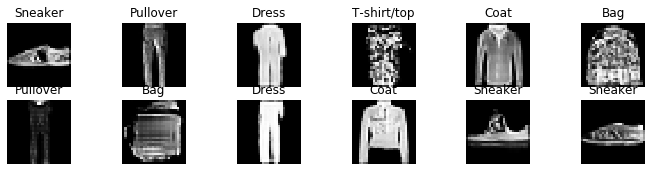

Epoch 28/100 G_loss : 4.299857 D_loss : 0.388436: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

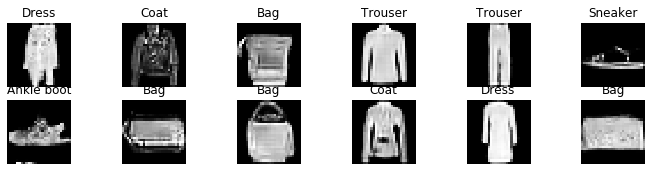

Epoch 29/100 G_loss : 4.245751 D_loss : 0.388075: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

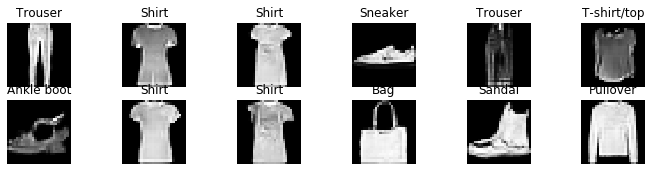

Epoch 30/100 G_loss : 4.333168 D_loss : 0.392247: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

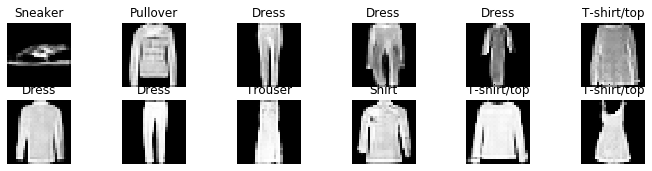

Epoch 31/100 G_loss : 4.353614 D_loss : 0.376537: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

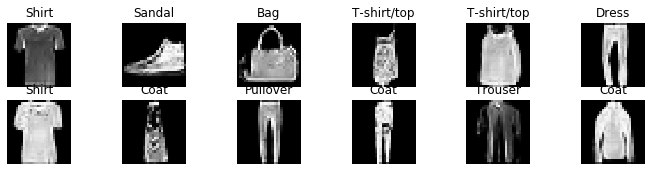

Epoch 32/100 G_loss : 4.409150 D_loss : 0.363149: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.37it/s]


<Figure size 864x288 with 0 Axes>

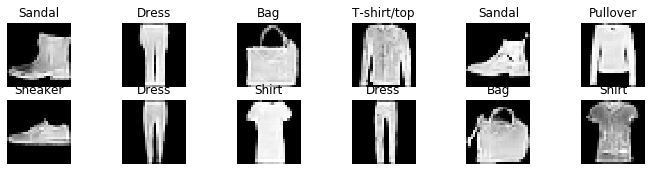

Epoch 33/100 G_loss : 4.425806 D_loss : 0.352827: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

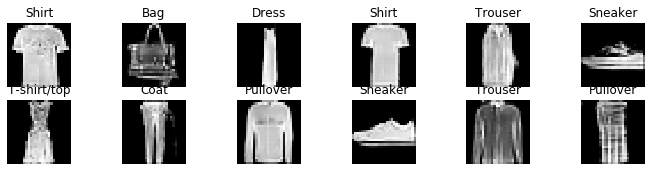

Epoch 34/100 G_loss : 4.455171 D_loss : 0.354896: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.38it/s]


<Figure size 864x288 with 0 Axes>

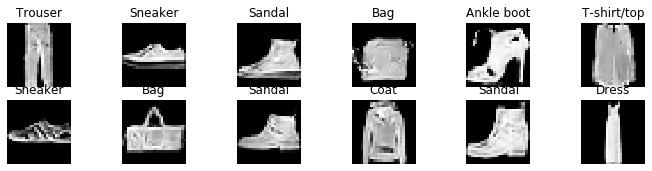

Epoch 35/100 G_loss : 4.492391 D_loss : 0.327760: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

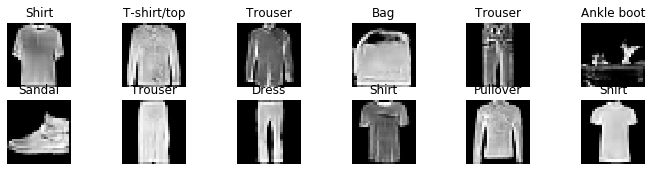

Epoch 36/100 G_loss : 4.544439 D_loss : 0.368285: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

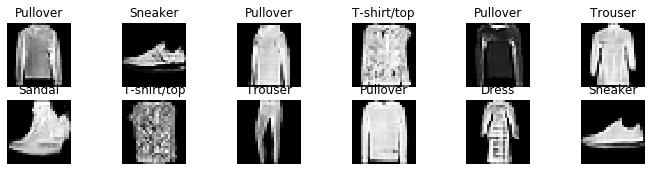

Epoch 37/100 G_loss : 4.529673 D_loss : 0.335337: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.44it/s]


<Figure size 864x288 with 0 Axes>

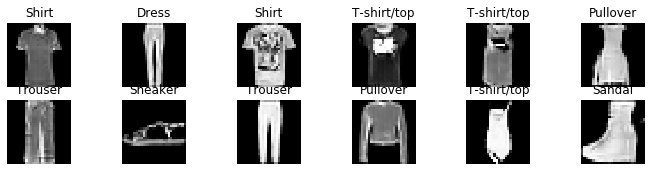

Epoch 38/100 G_loss : 4.552180 D_loss : 0.304130: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

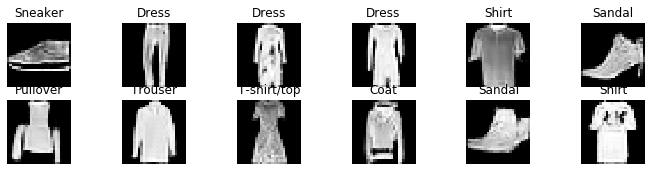

Epoch 39/100 G_loss : 4.585749 D_loss : 0.301679: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

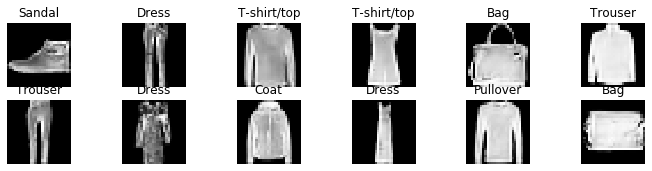

Epoch 40/100 G_loss : 4.740759 D_loss : 0.309148: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

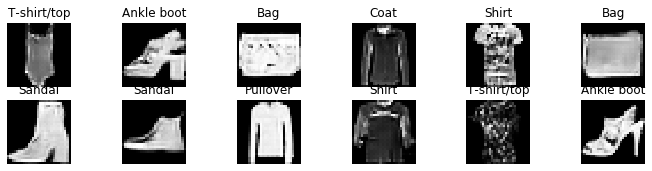

Epoch 41/100 G_loss : 4.714972 D_loss : 0.282860: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

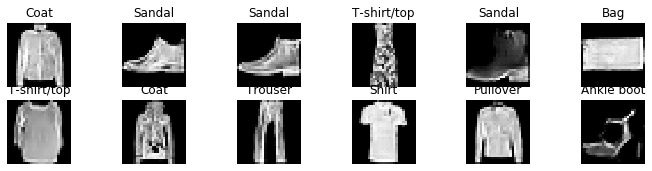

Epoch 42/100 G_loss : 4.788490 D_loss : 0.338427: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

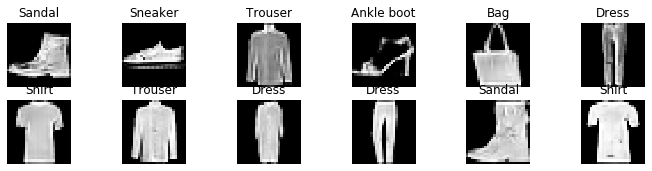

Epoch 43/100 G_loss : 4.727919 D_loss : 0.283254: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

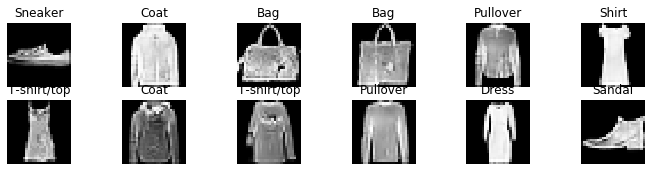

Epoch 44/100 G_loss : 4.846280 D_loss : 0.292009: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

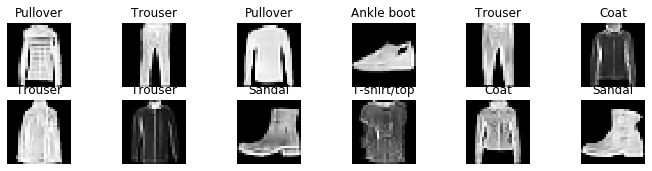

Epoch 45/100 G_loss : 4.756026 D_loss : 0.276229: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

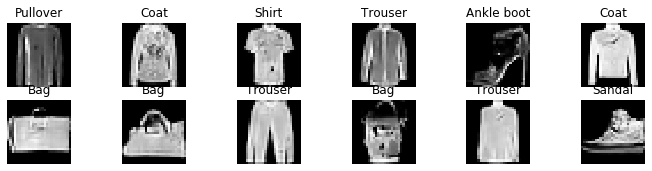

Epoch 46/100 G_loss : 4.834567 D_loss : 0.309302: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

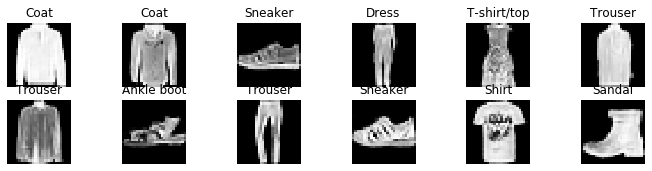

Epoch 47/100 G_loss : 4.889353 D_loss : 0.275792: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

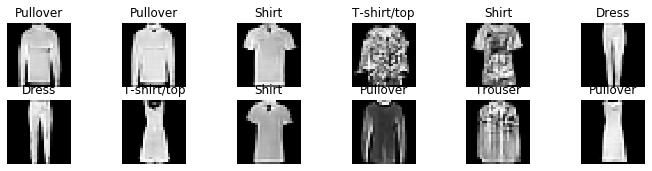

Epoch 48/100 G_loss : 4.923264 D_loss : 0.279038: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.43it/s]


<Figure size 864x288 with 0 Axes>

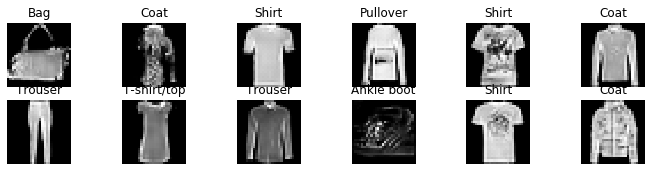

Epoch 49/100 G_loss : 4.928712 D_loss : 0.245117: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

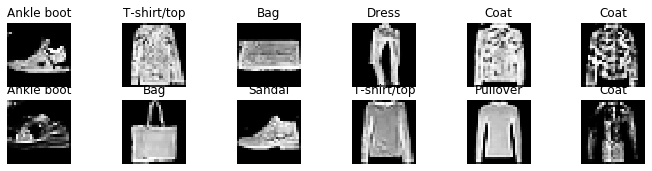

Epoch 50/100 G_loss : 4.951834 D_loss : 0.261057: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

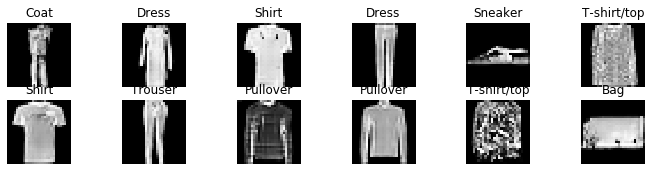

Epoch 51/100 G_loss : 4.977776 D_loss : 0.278285: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

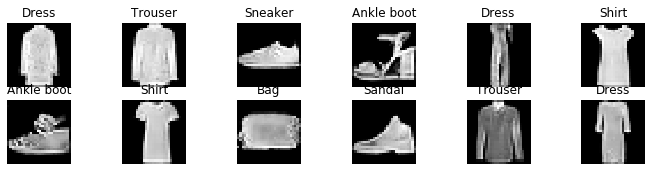

Epoch 52/100 G_loss : 4.985003 D_loss : 0.263836: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

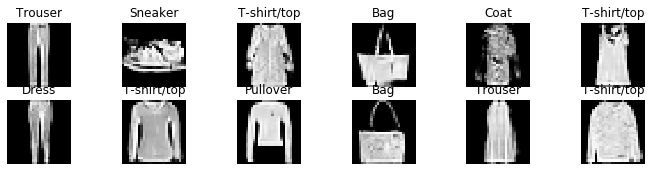

Epoch 53/100 G_loss : 5.011225 D_loss : 0.284714: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

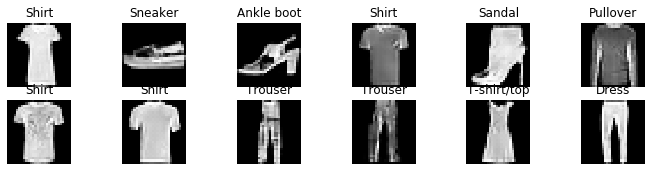

Epoch 54/100 G_loss : 5.033255 D_loss : 0.245356: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

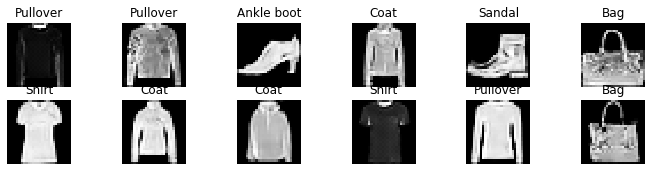

Epoch 55/100 G_loss : 5.052531 D_loss : 0.229633: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

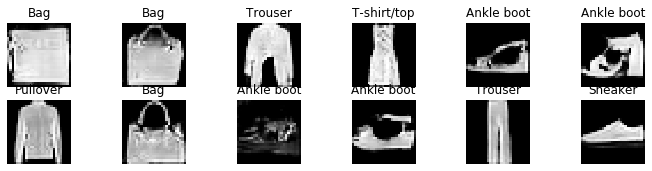

Epoch 56/100 G_loss : 5.097996 D_loss : 0.286889: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

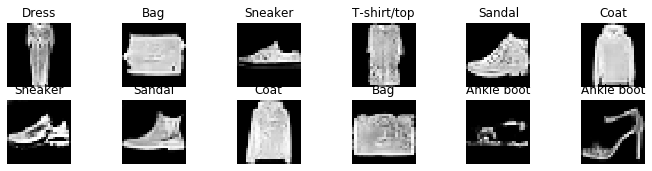

Epoch 57/100 G_loss : 5.103401 D_loss : 0.254175: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.43it/s]


<Figure size 864x288 with 0 Axes>

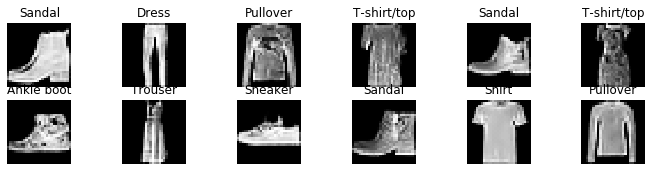

Epoch 58/100 G_loss : 5.150125 D_loss : 0.223360: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

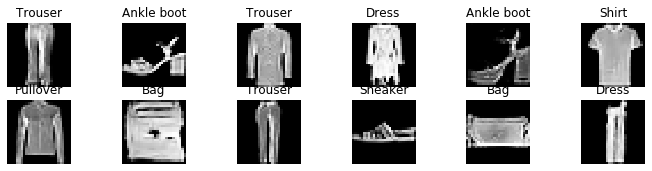

Epoch 59/100 G_loss : 5.243913 D_loss : 0.229923: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

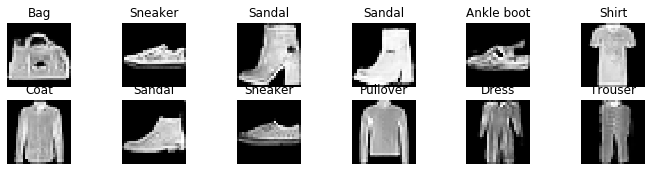

Epoch 60/100 G_loss : 5.212234 D_loss : 0.273369: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

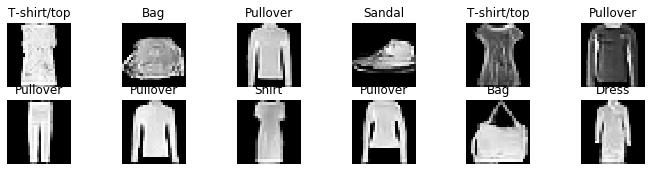

Epoch 61/100 G_loss : 5.210646 D_loss : 0.216351: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

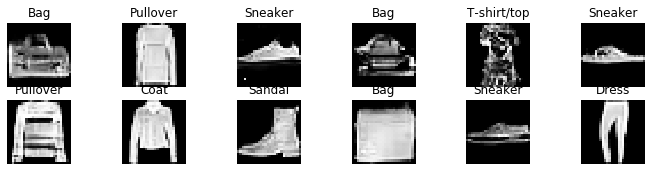

Epoch 62/100 G_loss : 5.305213 D_loss : 0.248745: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

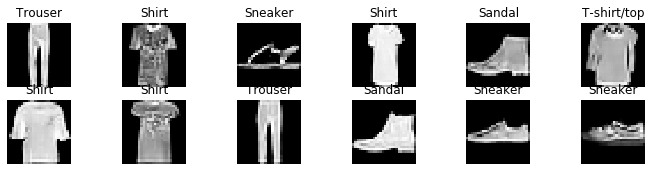

Epoch 63/100 G_loss : 5.318378 D_loss : 0.218982: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.44it/s]


<Figure size 864x288 with 0 Axes>

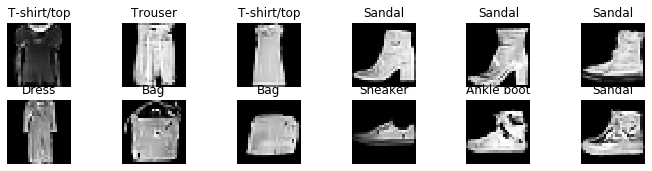

Epoch 64/100 G_loss : 5.307165 D_loss : 0.208482: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

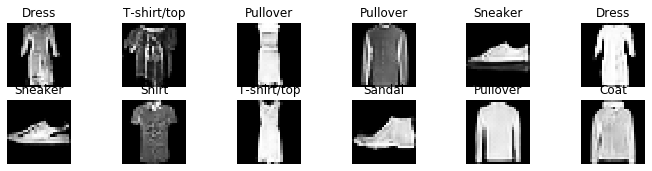

Epoch 65/100 G_loss : 5.361932 D_loss : 0.255659: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

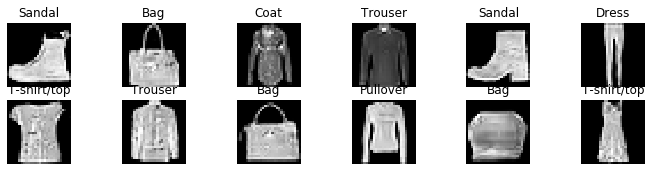

Epoch 66/100 G_loss : 5.376980 D_loss : 0.234610: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

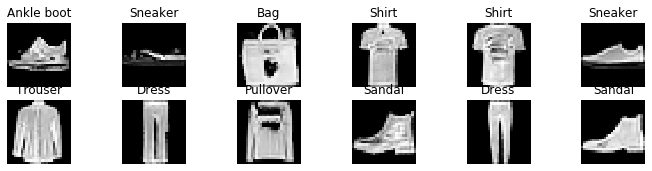

Epoch 67/100 G_loss : 5.404994 D_loss : 0.234490: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

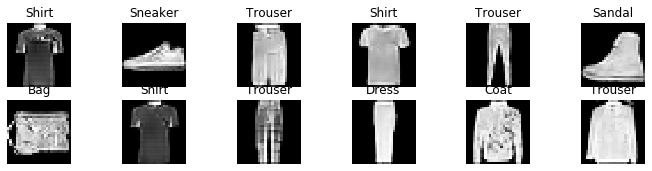

Epoch 68/100 G_loss : 5.426099 D_loss : 0.198024: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

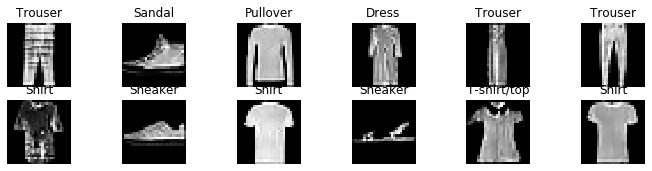

Epoch 69/100 G_loss : 5.455629 D_loss : 0.210993: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

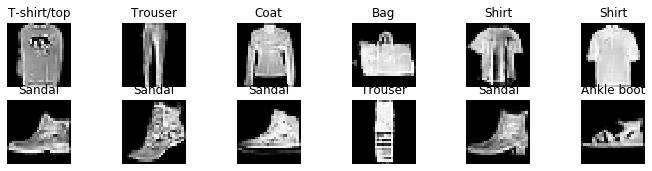

Epoch 70/100 G_loss : 5.537441 D_loss : 0.207397: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

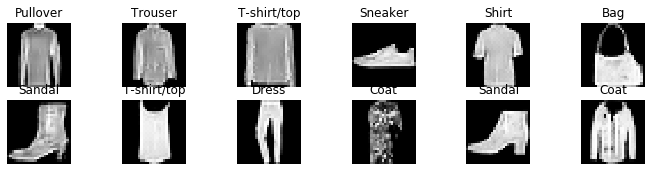

Epoch 71/100 G_loss : 5.454557 D_loss : 0.220663: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.43it/s]


<Figure size 864x288 with 0 Axes>

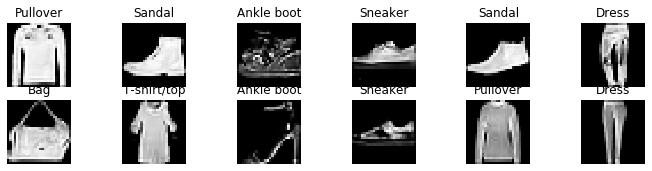

Epoch 72/100 G_loss : 5.469506 D_loss : 0.178904: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

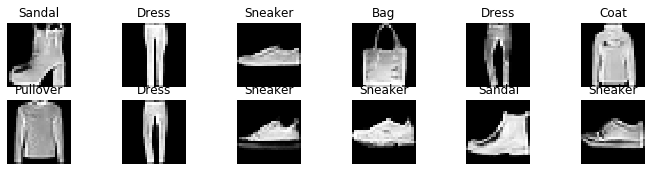

Epoch 73/100 G_loss : 5.579928 D_loss : 0.221314: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

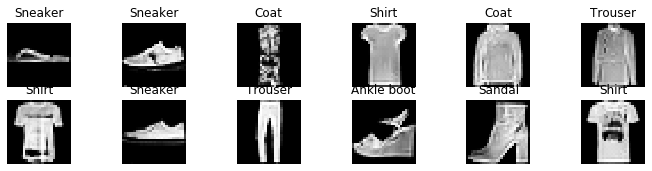

Epoch 74/100 G_loss : 5.500789 D_loss : 0.201815: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

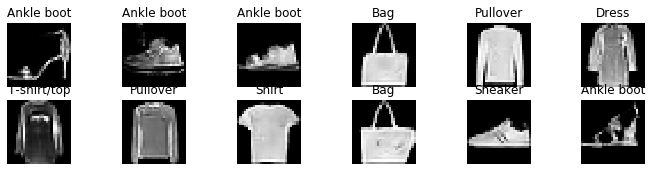

Epoch 75/100 G_loss : 5.500101 D_loss : 0.220192: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

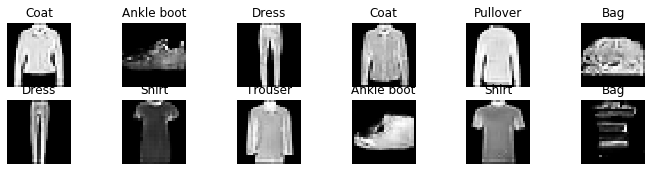

Epoch 76/100 G_loss : 5.647624 D_loss : 0.184605: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

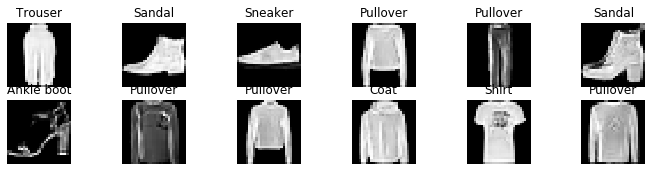

Epoch 77/100 G_loss : 5.562872 D_loss : 0.202988: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

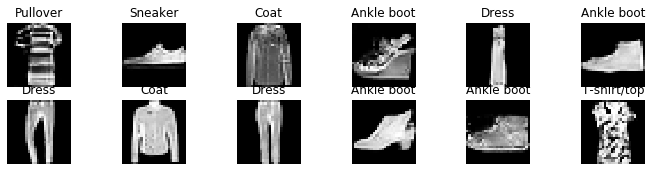

Epoch 78/100 G_loss : 5.612874 D_loss : 0.196782: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

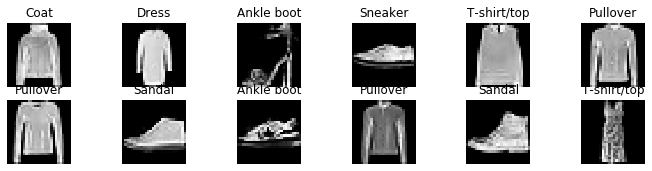

Epoch 79/100 G_loss : 5.716917 D_loss : 0.184207: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

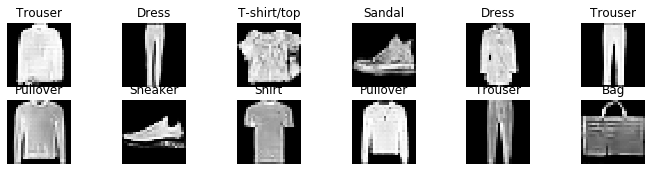

Epoch 80/100 G_loss : 5.786189 D_loss : 0.216102: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

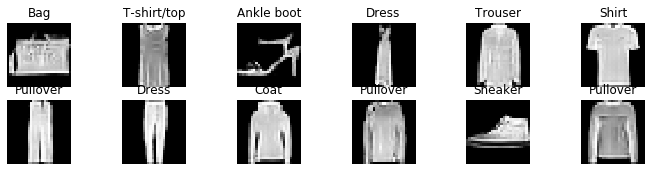

Epoch 81/100 G_loss : 5.637780 D_loss : 0.179056: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

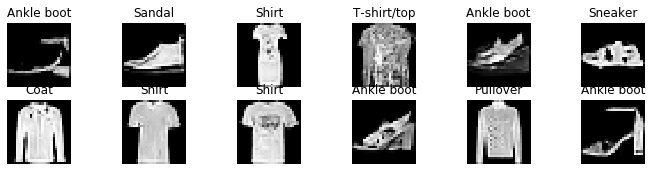

Epoch 82/100 G_loss : 5.858399 D_loss : 0.183389: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

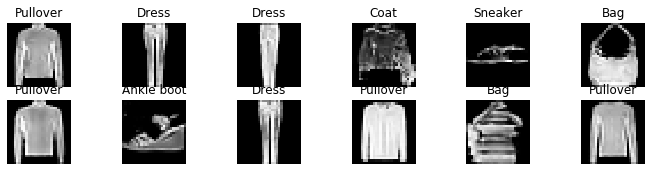

Epoch 83/100 G_loss : 5.874012 D_loss : 0.153848: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

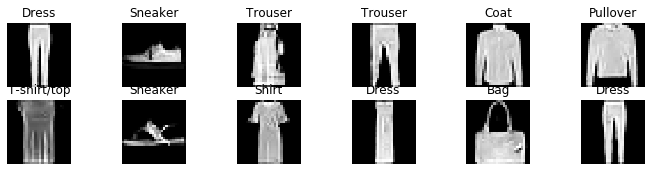

Epoch 84/100 G_loss : 5.972944 D_loss : 0.169430: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

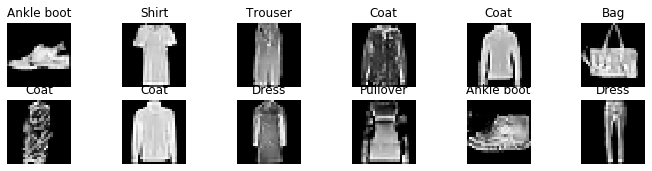

Epoch 85/100 G_loss : 5.910794 D_loss : 0.184192: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

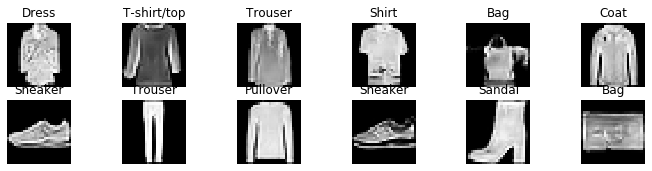

Epoch 86/100 G_loss : 5.952794 D_loss : 0.195826: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

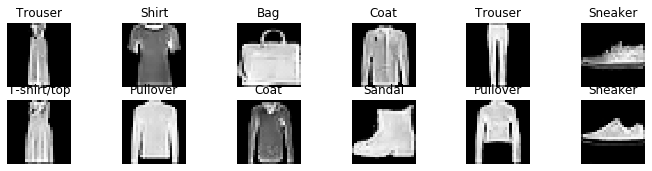

Epoch 87/100 G_loss : 5.899610 D_loss : 0.193656: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

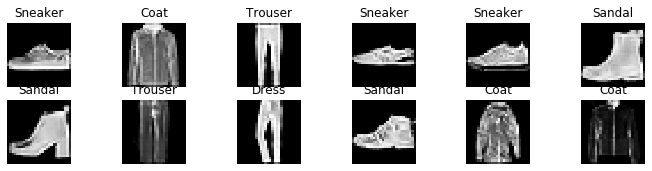

Epoch 88/100 G_loss : 5.832188 D_loss : 0.160895: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.38it/s]


<Figure size 864x288 with 0 Axes>

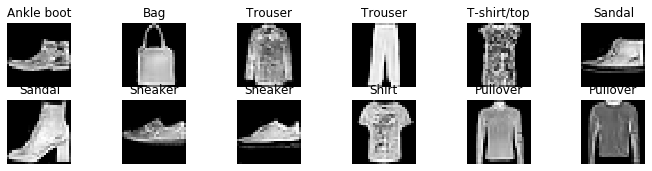

Epoch 89/100 G_loss : 6.049535 D_loss : 0.190799: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.42it/s]


<Figure size 864x288 with 0 Axes>

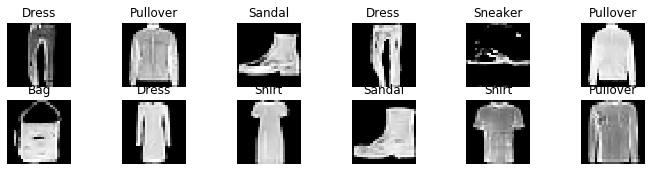

Epoch 90/100 G_loss : 5.888042 D_loss : 0.148808: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

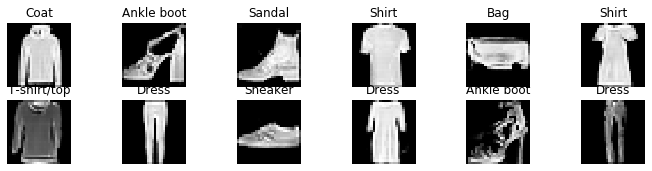

Epoch 91/100 G_loss : 6.137070 D_loss : 0.186678: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.41it/s]


<Figure size 864x288 with 0 Axes>

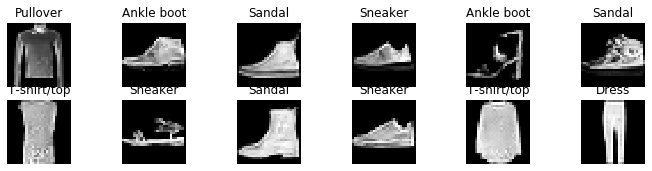

Epoch 92/100 G_loss : 5.825008 D_loss : 0.147032: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

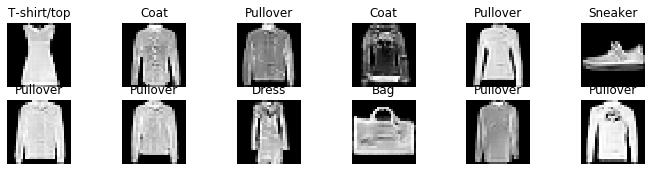

Epoch 93/100 G_loss : 6.058332 D_loss : 0.156582: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

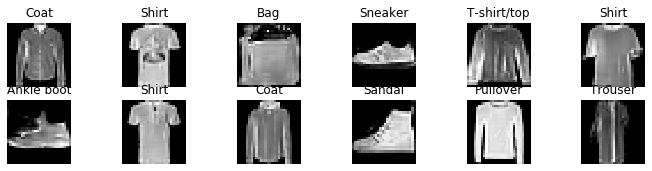

Epoch 94/100 G_loss : 6.102866 D_loss : 0.160812: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

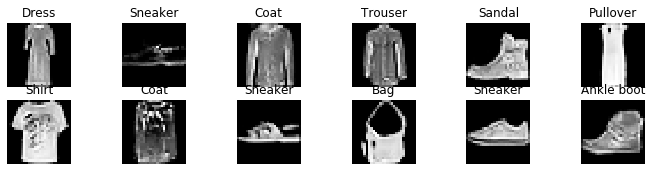

Epoch 95/100 G_loss : 6.169380 D_loss : 0.167984: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

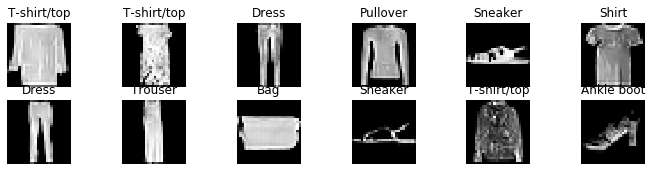

Epoch 96/100 G_loss : 6.047463 D_loss : 0.174790: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

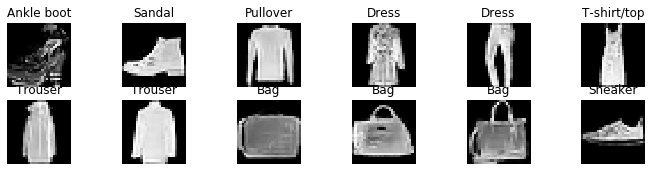

Epoch 97/100 G_loss : 6.153715 D_loss : 0.168069: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.39it/s]


<Figure size 864x288 with 0 Axes>

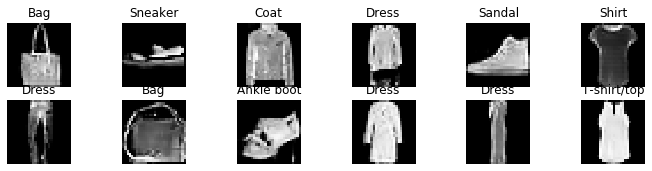

Epoch 98/100 G_loss : 6.152984 D_loss : 0.167240: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.38it/s]


<Figure size 864x288 with 0 Axes>

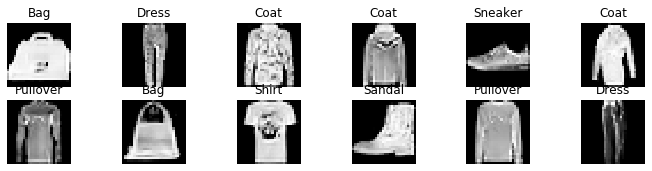

Epoch 99/100 G_loss : 6.119037 D_loss : 0.161954: 100%|██████████████████████████████| 937/937 [00:43<00:00, 21.40it/s]


<Figure size 864x288 with 0 Axes>

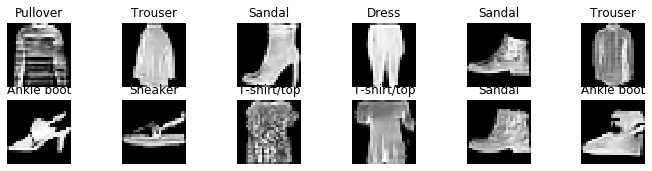

In [18]:
for epoch in range(epochs):
    d_losses = []
    g_losses = []
    
    D.train()
    G.train()
    
    pgbar = tqdm.tqdm(train_gen, total=len(train_gen))
    for real, y_vec in pgbar:
        
        real   = real.to(device)
        y_vec  = y_vec.to(device)
        target = torch.max(y_vec, axis=-1)[1]
        
        # train Discriminator
        z     = sample_z(batch_size).to(device)
        
        fake = G(z, y_vec)
        
        optim_D.zero_grad()
        d_loss = loss_fn_D(D, G, real, fake, target)
        d_loss.backward()
        optim_D.step()
    
        # train Generator
        z    = sample_z(batch_size).to(device)
        
        fake = G(z, y_vec)
        
        optim_G.zero_grad()
        g_loss = loss_fn_G(D, G, fake, target)
        g_loss.backward()
        optim_G.step()
        
        # print
        d_losses.append(d_loss.detach().cpu().numpy())
        g_losses.append(g_loss.detach().cpu().numpy())
        
        pgbar.set_description(f"Epoch {epoch}/{epochs} G_loss : {get_mean(g_losses):.6f} D_loss : {get_mean(d_losses):.6f}")

    # visualize
    D.eval()
    G.eval()
    
    show_num = 12
    
    class_names = []
    target_vecs = torch.zeros(show_num, class_num).to(device)
    for i in range(show_num):
        cls_num = random.randint(0, class_num-1)
        target_vecs[i, cls_num] = 1
        class_names.append(classes[cls_num])
    
    z = sample_z(show_num).to(device)
    fake = G(z, target_vecs)
    
    imshow(fake.detach().cpu().numpy().reshape(-1, 28, 28), class_names)

## Target Generating

In [19]:
def target_generate(idx, show_num=6):
    class_names = []
    target_vecs = torch.zeros(show_num, class_num).to(device)
    for i in range(show_num):
        target_vecs[i, idx] = 1
        class_names.append(classes[idx])

    z = sample_z(show_num).to(device)
    fake = G(z, target_vecs)

    imshow(fake.detach().cpu().numpy().reshape(-1, 28, 28), class_names)

<Figure size 864x288 with 0 Axes>

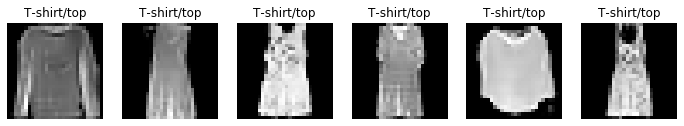

In [20]:
target_generate(0)

<Figure size 864x288 with 0 Axes>

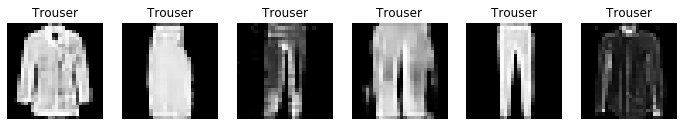

In [21]:
target_generate(1)

<Figure size 864x288 with 0 Axes>

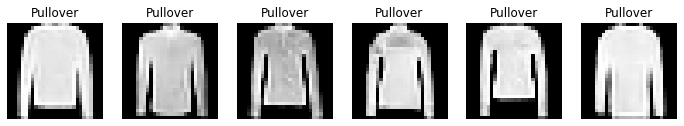

In [22]:
target_generate(2)

<Figure size 864x288 with 0 Axes>

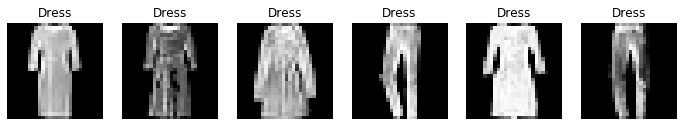

In [23]:
target_generate(3)

<Figure size 864x288 with 0 Axes>

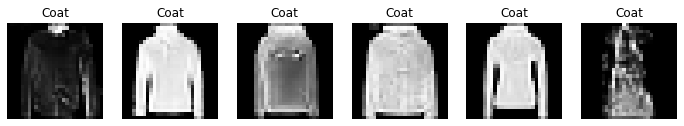

In [24]:
target_generate(4)

<Figure size 864x288 with 0 Axes>

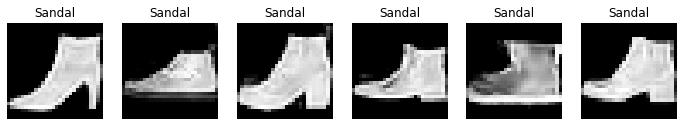

In [25]:
target_generate(5)

<Figure size 864x288 with 0 Axes>

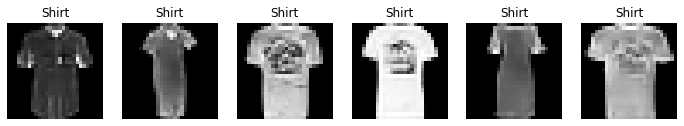

In [26]:
target_generate(6)

<Figure size 864x288 with 0 Axes>

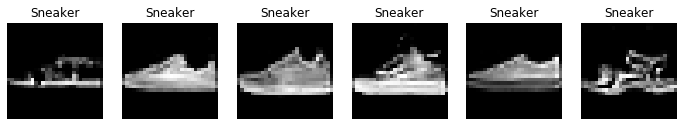

In [27]:
target_generate(7)

<Figure size 864x288 with 0 Axes>

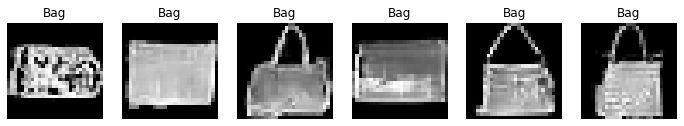

In [28]:
target_generate(8)

<Figure size 864x288 with 0 Axes>

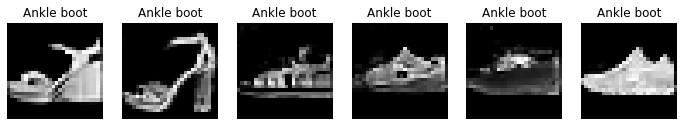

In [29]:
target_generate(9)